# Example for locus specific TRN inference: perturbation of STARR-seq
Inference of transcriptional regulatory networks (TRNs) at specific loci is complex and dynamic, posing significant challenges. However, ChromBERTs offer a solution for this intricate task. In this tutorial, we will guide you through the process of locus-specific TRN inference, using the example of modelling perturbation effect of STARR-seq.  
Note: tutorials for EZH2 is suggested to be read before this tutorial. 

In [11]:
import  os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # to selected gpu used 

import sys 
import torch 
import numpy as np 
import pandas as pd 
from tqdm import tqdm 
from matplotlib import pyplot as plt
import chrombert
from torchinfo import summary

import scipy 
import h5py 
from sklearn.metrics.pairwise import cosine_similarity
import lightning.pytorch as pl
basedir =  os.path.expanduser("~/.cache/chrombert/data")



## Fine-tune

### Dataset
The first step is to prepare the dataset. The dataset used for perturbation task is similiar with other tasks, except the column `perturbation_object`, which sets the perturbation target for each sample.   
It can be a list of data accession joined by `;`, or just transcription regulator names joined by `;`.  If no perturbation for the sample, set it as `None`, or str `"none"`.   
The `perturbation_object` can be set for each sample respectively, or set for all samples in the dataset. For the latter case, setting it in the config.   
Note: **config setting will overwrite the sample setting.**

In [12]:
# below is a example setting `per`
supervised_train = os.path.join(basedir, "demo", "starr", "train.csv")
df_train = pd.read_csv(supervised_train)
df_train

,chrom,start,end,build_region_index,label,perturbation_object
0,chr1,199241128,199242128,141732,1.956989,NaN
1,chr1,107707622,107708622,87175,2.505805,NaN
2,chr10,127935569,127936569,281197,2.637493,NaN
3,chr2,72258130,72259130,975449,1.491235,NaN
4,chr8,33612518,33613518,1889869,1.761900,NaN
...,...,...,...,...,...,...
34813,chr4,1388788,1389788,1355108,3.686819,GSM1121096;GSM1296385;GSM1313922
34814,chrX,3651041,3652041,2061995,0.914363,GSM602291;GSM449527;GSM525270;GSM525268;GSM393...
34815,chr5,135488689,135489689,1580262,1.735307,GSM971946;GSM1247824;GSM1328971;GSM1665999;GSM...
34816,chr10,87317757,87318757,247977,1.701492,GSM971946;GSM1247824;GSM1328971;GSM1665999;GSM...


In [13]:
dc = chrombert.get_preset_dataset_config(
    "general", supervised_file = supervised_train, 
    perturbation = True, 
    perturbation_value = 0 # choose from [0,1,2,3,4]. 0 is similar to knock-out perturbation, 4 is similar to over-expression perturbation.
    # you can also set `perturbartion_object` here, e.g "EP300;CREBBP" ,to override the setting in the supervised file.
    )
print(dc)

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
{
    "hdf5_file": "/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5",
    "supervised_file": "/home/yangdongxu/.cache/chrombert/data/demo/starr/train.csv",
    "kind": "GeneralDataset",
    "meta_file": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json",
    "ignore": false,
    "ignore_object": null,
    "batch_size": 8,
    "num_workers": 20,
    "shuffle": false,
    "perturbation": true,
    "perturbation_object": null,
    "perturbation_value": 0,
    "prompt_kind": null,
    "prompt_regulator": null,
    "prompt_regulator_cache_file": null,
    "prompt_celltype": null,
    "prompt_celltype_cache_file": null,
    "fasta_file": null,
    "flank_window": 0
}


In [14]:
ds = dc.init_dataset()
ds[1] # now the input_ids is perturbed. `input_ids` is the tokenized sequence, where 5-9 corresponds to 0-4 level of signal level

use perturbation_object in supervised_file


{'input_ids': tensor([5, 6, 5,  ..., 6, 6, 5], dtype=torch.int8),
 'position_ids': tensor([   1,    2,    3,  ..., 6389, 6390, 6391]),
 'region': tensor([        1, 107165000, 107166000], dtype=torch.int32),
 'build_region_index': np.int64(87175),
 'label': np.float64(2.505804511612648)}

The dataset can be used combining with `ignore` ability. Here we ignore all other regulators, considering transcription factors only. 

In [15]:
ignores="DNase;ATAC-seq;H3K4me1;H3K27me3;H3K9me3;H3K23me2;H4K20me1;H4K5ac;H2BK5ac;H2BK12ac;H3K18ac;H3K4me2;H3K79me2;H4K91ac;H3K9ac;H3K9K14ac;H3.3,H2A.Z;H3K4me3;H3K36me3;H2BK120ac;H2AK9ac;H3K14ac;H2BK15ac;H3K23ac;H2BK20ac;H3K4ac;H3K56ac;H3K79me1;H4K8ac;H3K27ac;H3K9me1;H4K16ac;Histone Lysine Acetylation;Histone Lysine Crotonylation;H3K36me2;H3T;H3ac;H2AK119ub;H2A;H4K5ac, H4K8ac, H4K12ac, H4K16ac;H3K122ac;H2AZK4ac, H2AZK7ac, H2AZK11ac;H2AX;H3.3;H2A.Bbd;H2AZac;H4K20me3;H4K12ac;H2AK5ac;H4ac;H3;CENPA;H1.2;H2Bub;H2AFY;H3R26Cit;H3K79me3;H4;H3K27me1;H3K9me2;H2AZ;H3F3A;H1.4;H1.0;H2AFY2;H3K36ac;H3K36me1;H2BK120ub;H3K18cr;H2AZ;H2AFX;H3F3B;faire"

dc = chrombert.get_preset_dataset_config(
    "general", supervised_file = supervised_train, 
    perturbation = True, 
    perturbation_value = 0, # choose from [0,1,2,3,4]. 0 is similar to knock-out perturbation, 4 is similar to over-expression perturbation.
    # you can also set `perturbartion_object` here, e.g "EP300;CREBBP" ,to override the setting in the supervised file.
    ignore = True, 
    ignore_object = ignores,
    batch_size = 1
    )
ds = dc.init_dataset()
ignore_index = ds[1]["ignore_index"]
ds[1]

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
use perturbation_object in supervised_file


{'input_ids': tensor([5, 5, 6,  ..., 6, 6, 5], dtype=torch.int8),
 'position_ids': tensor([2997, 2999, 3000,  ..., 6389, 6390, 6391]),
 'region': tensor([        1, 107165000, 107166000], dtype=torch.int32),
 'build_region_index': np.int64(87175),
 'ignore_index': (array([1146, 2432,  380, ..., 1373, 1392, 2944]),
  array([ 25, 100, 146, 207, 271, 272, 273, 274, 275, 276, 277, 278, 279,
         280, 281, 282, 283, 285, 284, 286, 287, 288, 289, 290, 291, 292,
         293, 294, 295, 326, 296, 297, 298, 299, 300, 301, 302, 303, 304,
         305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
         318, 320, 319, 321, 322, 323, 324, 325, 327, 336, 328, 329, 330,
         331, 332, 333, 334, 335, 384, 385])),
 'label': np.float64(2.505804511612648)}

### Load model
Loading the model follows the same procedure as for other tasks.

In [16]:
mc = chrombert.get_preset_model_config(
    "general", 
    ignore = True, 
    ignore_index = ignore_index,
    dropout = 0.1 # to fine-tune the model
)
print(mc)

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
ChromBERTFTConfig(genome='hg38', task='general', dim_output=1, mtx_mask='/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_mask_matrix.tsv', dropout=0.1, pretrain_ckpt='/home/yangdongxu/.cache/chrombert/data/checkpoint/hg38_6k_1kb_pretrain.ckpt', finetune_ckpt=None, ignore=True, ignore_index=(array([1146, 2432,  380, ..., 1373, 1392, 2944]), array([ 25, 100, 146, 207, 271, 272, 273, 274, 275, 276, 277, 278, 279,
       280, 281, 282, 283, 285, 284, 286, 287, 288, 289, 290, 291, 292,
       293, 294, 295, 326, 296, 297, 298, 299, 300, 301, 302, 303, 304,
       305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
       318, 320, 319, 321, 322, 323, 324, 325, 327, 336, 328, 329, 330,
       331, 332, 333, 334, 335, 384, 385])), gep_flank_window=4, gep_parallel_embedding=False, gep_gradient_checkpoint=False, gep_zero_inflation=True, prompt_kind='cistrom

In [17]:
model = mc.init_model().cuda().bfloat16()
model.freeze_pretrain(trainable=2)
summary(model)

use organisim hg38; max sequence length including cls is 6392


/home/yangdongxu/.conda/envs/demo/lib/python3.9/site-packages/chrombert/base/model.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(ckpt_path, map_locati

Ignoring 3044 cistromes and 72 regulators


Layer (type:depth-idx)                                  Param #
ChromBERTGeneral                                        --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         (7,680)
│    │    └─PositionalEmbedding: 3-2                    (4,909,056)
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-5                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-6                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-7                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-8                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-9                (6,497,280)
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock


### Fine-tune
We provide a simple fine-tuning demo here. For real usage, please refer to the scripts in the examples/train directory.


In [18]:
data_module = chrombert.LitChromBERTFTDataModule(
    config = dc.clone(batch_size=8),
    train_params = dict(supervised_file = os.path.join(basedir, "demo", "starr", "train.csv")),
    val_params = dict(supervised_file = os.path.join(basedir, "demo", "starr", "valid.csv")),
    test_params = dict(supervised_file = os.path.join(basedir, "demo", "starr", "test.csv")),
)
data_module

In [19]:
# Parameters here were set to accelerate the training process for the tutorial, but not recommended for real tasks. 
# See our manuscript for more details about hyperparameters.
# The fine-tune process here need ~30 minutes on a single NVIDIA A100 GPU.
tc = chrombert.finetune.train.TrainConfig(
    kind = "regression",
    loss = "rmse", # use rmse loss because it's a regression task,
    max_epochs = 2, # it's too small to get a good result, but it's just a demo
    lr = 1e-4, # it's too large to get a good result, but it's just a demo
    val_check_interval = 0.1,
    limit_val_batches = 1.0,
    accumulate_grad_batches = 8,
) # for 
pl_module = tc.init_pl_module(model) # wrap model with PyTorch Lightning module
type(pl_module)

/home/yangdongxu/.conda/envs/demo/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


chrombert.finetune.train.pl_module.RegressionPLModule

In [20]:
trainer = tc.init_trainer(precision = "bf16")
trainer.fit(pl_module, data_module)

/home/yangdongxu/.conda/envs/demo/lib/python3.9/site-packages/lightning/fabric/connector.py:571: `precision=bf16` is supported for historical reasons but its usage is discouraged. Please set your precision to bf16-mixed instead!
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


use perturbation_object in supervised_file
use perturbation_object in supervised_file
use perturbation_object in supervised_file


Loading `train_dataloader` to estimate number of stepping batches.

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | ChromBERTGeneral | 62.6 M | train
---------------------------------------------------
18.7 M    Trainable params
43.9 M    Non-trainable params
62.6 M    Total params
250.431   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/yangdongxu/.conda/envs/demo/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 54: 'default_validation/rmse' reached 0.85927 (best 0.85927), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=54.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 108: 'default_validation/rmse' reached 0.85400 (best 0.85400), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=108.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 163: 'default_validation/rmse' reached 0.84246 (best 0.84246), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=163.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 217: 'default_validation/rmse' reached 0.83560 (best 0.83560), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=217.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 271: 'default_validation/rmse' reached 0.83365 (best 0.83365), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=271.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 326: 'default_validation/rmse' reached 0.81143 (best 0.81143), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=326.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 380: 'default_validation/rmse' reached 0.79347 (best 0.79347), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=380.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 435: 'default_validation/rmse' reached 0.79089 (best 0.79089), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=435.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 489: 'default_validation/rmse' reached 0.76751 (best 0.76751), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=489.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 543: 'default_validation/rmse' reached 0.76482 (best 0.76482), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=0-step=543.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 599: 'default_validation/rmse' reached 0.76231 (best 0.76231), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=1-step=599.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 653: 'default_validation/rmse' reached 0.75945 (best 0.75945), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=1-step=653.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 708: 'default_validation/rmse' reached 0.75286 (best 0.75286), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=1-step=708.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 762: 'default_validation/rmse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 816: 'default_validation/rmse' reached 0.75034 (best 0.75034), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=1-step=816.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 871: 'default_validation/rmse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 925: 'default_validation/rmse' reached 0.74910 (best 0.74910), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=1-step=925.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 980: 'default_validation/rmse' reached 0.74903 (best 0.74903), saving model to '/home/yangdongxu/repos/ChromBERT/examples/tutorials/lightning_logs/chrombert-ft/version_1/checkpoints/epoch=1-step=980.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1034: 'default_validation/rmse' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1088: 'default_validation/rmse' was not in top 1
`Trainer.fit` stopped: `max_epochs=2` reached.


Checkpoints will be save in `lightning_logs` directory automately, and the last checkpoint can be saved like below. 

In [21]:
if not os.path.exists("tmp_starr"):
    os.makedirs("tmp_starr")
pl_module.save_ckpt(os.path.join("tmp_starr", "starr.ckpt"))

## Load fine-tuned model

### Load model

In [22]:
# we load the model from the last checkpoint file because of in-sufficient traing. 
# However, it's recommend to check other checkpoints to avoid over-fitting.
ckpt = os.path.join("tmp_starr", "starr.ckpt")

In [23]:
model = chrombert.get_preset_model_config(
    "general", ignore = True, ignore_index = ignore_index,
    dropout = 0, 
    finetune_ckpt = os.path.abspath(ckpt)
).init_model().cuda().bfloat16().eval()
summary(model)

update path: mtx_mask = config/hg38_6k_mask_matrix.tsv
update path: pretrain_ckpt = checkpoint/hg38_6k_1kb_pretrain.ckpt
update path: finetune_ckpt = /home/yangdongxu/repos/ChromBERT/examples/tutorials/tmp_starr/starr.ckpt
use organisim hg38; max sequence length including cls is 6392


/home/yangdongxu/.conda/envs/demo/lib/python3.9/site-packages/chrombert/base/model.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(ckpt_path, map_locati

Ignoring 3044 cistromes and 72 regulators
Loading checkpoint from /home/yangdongxu/repos/ChromBERT/examples/tutorials/tmp_starr/starr.ckpt
Loaded 110/110 parameters


/home/yangdongxu/.conda/envs/demo/lib/python3.9/site-packages/chrombert/finetune/model/basic_model.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_state = torch.loa

Layer (type:depth-idx)                                  Param #
ChromBERTGeneral                                        --
├─ChromBERT: 1-1                                        --
│    └─BERTEmbedding: 2-1                               --
│    │    └─TokenEmbedding: 3-1                         7,680
│    │    └─PositionalEmbedding: 3-2                    4,909,056
│    │    └─Dropout: 3-3                                --
│    └─ModuleList: 2-2                                  --
│    │    └─EncoderTransformerBlock: 3-4                6,497,280
│    │    └─EncoderTransformerBlock: 3-5                6,497,280
│    │    └─EncoderTransformerBlock: 3-6                6,497,280
│    │    └─EncoderTransformerBlock: 3-7                6,497,280
│    │    └─EncoderTransformerBlock: 3-8                6,497,280
│    │    └─EncoderTransformerBlock: 3-9                6,497,280
│    │    └─EncoderTransformerBlock: 3-10               6,497,280
│    │    └─EncoderTransformerBlock: 3-11          

### Load dataset

In this tutorial, we use the following dataset to evaluate the model's performance. This dataset consists of a transformed and reshaped test file for convenience. 

The `wt` column represents the wild type STARR-seq data, while the `ep300` column contains the STARR-seq signal from EP300/CREBBP knockdown cells.


In [24]:
supervised_file = os.path.join(basedir, "demo", "starr", "supervised.csv")
!head $supervised_file

chrom,start,end,build_region_index,wt,ep300,diff,kind
chr6,13307232,13308232,1627400,0.9889573548313711,1.38310498787305,0.39414763304167877,nochange
chr1,231663746,231664746,169607,2.4807076319328907,1.9394034879228463,-0.5413041440100443,other
chr10,1155940,1156940,184962,1.3925053029992234,0.8553238049917151,-0.5371814980075083,other
chrX,113511225,113512225,2114528,0.9910568962803128,1.1759059510981291,0.18484905481781633,nochange
chr1,103345556,103346556,84878,0.8908197542965414,0.0901858722270683,-0.8006338820694731,other
chr5,92694706,92695706,1548713,2.934648243515996,1.2105942864339372,-1.7240539570820588,decrease
chr10,115111759,115112759,270229,1.5381286882444107,1.390405495436994,-0.14772319280741675,nochange
chr4,5665727,5666727,1358762,1.335261459502083,1.7218760458360476,0.3866145863339645,nochange
chr3,77623151,77624151,1265465,2.313793644637294,2.2775156832307086,-0.03627796140658557,nochange


In [25]:
df_supervised = pd.read_csv(supervised_file)
df_supervised

,chrom,start,end,build_region_index,wt,ep300,diff,kind
0,chr6,13307232,13308232,1627400,0.988957,1.383105,0.394148,nochange
1,chr1,231663746,231664746,169607,2.480708,1.939403,-0.541304,other
2,chr10,1155940,1156940,184962,1.392505,0.855324,-0.537181,other
3,chrX,113511225,113512225,2114528,0.991057,1.175906,0.184849,nochange
4,chr1,103345556,103346556,84878,0.890820,0.090186,-0.800634,other
...,...,...,...,...,...,...,...,...
716,chr4,189862154,189863154,1481367,1.957393,0.597990,-1.359403,decrease
717,chr2,194444725,194445725,1059645,0.412500,0.639412,0.226912,nochange
718,chr10,3509192,3510192,186897,1.316483,0.583072,-0.733411,other
719,chr5,173391003,173392003,1609640,1.145941,0.897721,-0.248220,nochange


In [26]:
dc_wt = chrombert.get_preset_dataset_config(
    "general", 
    ignore = True, 
    ignore_object = ignores,
    perturbation = False, # for the wild-type dataset, we set perturbation to False
    perturbation_object = "none", # we set it to "none" to make sure the perturbation is not applied
    perturbation_value = 0, 
    supervised_file = supervised_file,
    shuffle = False,
    batch_size = 4
)
dc_ep300 = dc_wt.clone(perturbation=True,perturbation_object = "crebbp;ep300") # we set perturbation = True and perturbation_object to "crebbp;ep300" to apply the perturbation
print(dc_wt), print(dc_ep300)

update path: hdf5_file = hg38_6k_1kb.hdf5
update path: meta_file = config/hg38_6k_meta.json
{
    "hdf5_file": "/home/yangdongxu/.cache/chrombert/data/hg38_6k_1kb.hdf5",
    "supervised_file": "/home/yangdongxu/.cache/chrombert/data/demo/starr/supervised.csv",
    "kind": "GeneralDataset",
    "meta_file": "/home/yangdongxu/.cache/chrombert/data/config/hg38_6k_meta.json",
    "ignore": true,
    "ignore_object": "DNase;ATAC-seq;H3K4me1;H3K27me3;H3K9me3;H3K23me2;H4K20me1;H4K5ac;H2BK5ac;H2BK12ac;H3K18ac;H3K4me2;H3K79me2;H4K91ac;H3K9ac;H3K9K14ac;H3.3,H2A.Z;H3K4me3;H3K36me3;H2BK120ac;H2AK9ac;H3K14ac;H2BK15ac;H3K23ac;H2BK20ac;H3K4ac;H3K56ac;H3K79me1;H4K8ac;H3K27ac;H3K9me1;H4K16ac;Histone Lysine Acetylation;Histone Lysine Crotonylation;H3K36me2;H3T;H3ac;H2AK119ub;H2A;H4K5ac, H4K8ac, H4K12ac, H4K16ac;H3K122ac;H2AZK4ac, H2AZK7ac, H2AZK11ac;H2AX;H3.3;H2A.Bbd;H2AZac;H4K20me3;H4K12ac;H2AK5ac;H4ac;H3;CENPA;H1.2;H2Bub;H2AFY;H3R26Cit;H3K79me3;H4;H3K27me1;H3K9me2;H2AZ;H3F3A;H1.4;H1.0;H2AFY2;H3K36ac;H

(None, None)

In [27]:
ds_wt = dc_wt.init_dataset()
ds_ep300 = dc_ep300.init_dataset()
ds_wt[1], ds_ep300[1]

Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
use perturbation_object in dataset config which high priority than supervised_file


({'input_ids': tensor([9, 9, 9,  ..., 6, 6, 9], dtype=torch.int8),
  'position_ids': tensor([2997, 2999, 3000,  ..., 6389, 6390, 6391]),
  'region': tensor([        1, 231528000, 231529000], dtype=torch.int32),
  'build_region_index': np.int64(169607),
  'ignore_index': (array([1146, 2432,  380, ..., 1373, 1392, 2944]),
   array([ 25, 100, 146, 207, 271, 272, 273, 274, 275, 276, 277, 278, 279,
          280, 281, 282, 283, 285, 284, 286, 287, 288, 289, 290, 291, 292,
          293, 294, 295, 326, 296, 297, 298, 299, 300, 301, 302, 303, 304,
          305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317,
          318, 320, 319, 321, 322, 323, 324, 325, 327, 336, 328, 329, 330,
          331, 332, 333, 334, 335, 384, 385]))},
 {'input_ids': tensor([9, 9, 9,  ..., 6, 6, 9], dtype=torch.int8),
  'position_ids': tensor([2997, 2999, 3000,  ..., 6389, 6390, 6391]),
  'region': tensor([        1, 231528000, 231529000], dtype=torch.int32),
  'build_region_index': np.int64(169607),
 

In [28]:
# some input signal levels are perturbed
np.bincount(ds_ep300[1]["input_ids"].numpy()), np.bincount(ds_wt[1]["input_ids"].numpy())

(array([   0,    0,    0,    0,    0,  113,  859,  221,  353, 1801]),
 array([   0,    0,    0,    0,    0,   63,  868,  225,  362, 1829]))

## Forward: get predictions

In [29]:
list_wt = []
list_ep300 = []
for (batch_wt, batch_ep300) in tqdm(zip(dc_wt.init_dataloader(), dc_ep300.init_dataloader())):
    for k,v in batch_wt.items():
        if isinstance(v, torch.Tensor):
            batch_wt[k] = v.cuda()
            batch_ep300[k] = batch_ep300[k].cuda()
    
    with torch.no_grad():
        logit_wt = model(batch_wt).float().cpu().numpy() # get the predictions of wild-type
        logit_ep300 = model(batch_ep300).float().cpu().numpy() 
    list_wt.append(logit_wt)
    list_ep300.append(logit_ep300)

logits_wt = np.concatenate(list_wt, axis=0).reshape(-1)
logits_ep300 = np.concatenate(list_ep300, axis=0).reshape(-1)

Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
use perturbation_object in dataset config which high priority than supervised_file


181it [00:13, 13.28it/s]


In [30]:
logits_wt.shape, logits_ep300.shape

((721,), (721,))

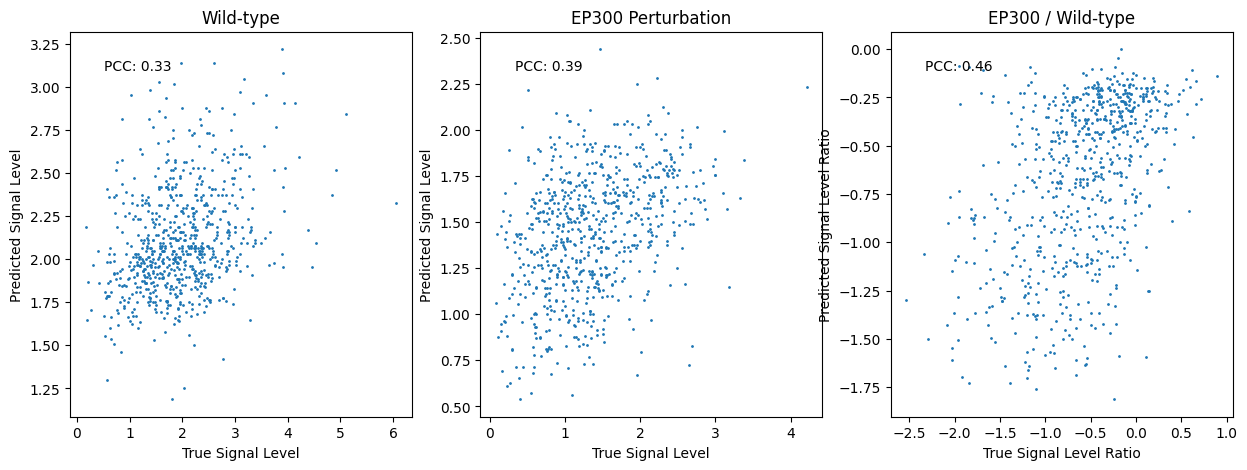

In [31]:
# We show the performance here. 
# Note: the performance is not good because the model is not well-trained.
fig, axs = plt.subplots(1,3,figsize=(15,5))
signal_wt = df_supervised["wt"].values
signal_ep300 = df_supervised["ep300"].values

ax = axs[0]
ax.scatter(signal_wt, logits_wt, s=1)
ax.set_xlabel("True Signal Level")
ax.set_ylabel("Predicted Signal Level")
ax.set_title("Wild-type")
pcc = scipy.stats.pearsonr(signal_wt, logits_wt)[0]
ax.text(0.1, 0.9, f"PCC: {pcc:.2f}", transform=ax.transAxes)

ax = axs[1]
ax.scatter(signal_ep300, logits_ep300, s=1)
ax.set_xlabel("True Signal Level")
ax.set_ylabel("Predicted Signal Level")
ax.set_title("EP300 Perturbation")
pcc = scipy.stats.pearsonr(signal_ep300, logits_ep300)[0]
ax.text(0.1, 0.9, f"PCC: {pcc:.2f}", transform=ax.transAxes)


ax = axs[2]
logit_diff = logits_ep300 - logits_wt
signal_diff = signal_ep300 - signal_wt
ax.scatter(signal_diff, logit_diff, s=1)
ax.set_xlabel("True Signal Level Ratio")
ax.set_ylabel("Predicted Signal Level Ratio")
ax.set_title("EP300 / Wild-type")
pcc = scipy.stats.pearsonr(signal_diff, logit_diff)[0]
ax.text(0.1, 0.9, f"PCC: {pcc:.2f}", transform=ax.transAxes)

plt.show()

## Forward: get embeddings
We use the regulator embedding from wild type and perturbed states to calculate embedding shifts.  
Intuitively, the embedding shift on enhancers sensitive to EP300/CREBBP perturbation is larger than the non-sensitive ones, and regulators associated with EP300/CREBBP should have larger embedding shifts on sensitive enhancers. 


In [32]:
from chrombert.scripts.utils import HDF5Manager # We provide a convenient class for store the embeddings

if not os.path.exists("tmp_starr"):
    os.makedirs("tmp_starr")

model_emb = model.get_embedding_manager()

dict_shapes = {
    "region":((len(ds_wt), 4), int), 
    "wt":((len(ds_wt),len(model_emb.list_regulator), 768), np.float16), 
    "ep300":((len(ds_wt),len(model_emb.list_regulator), 768), np.float16)
    } # initialize the shapes of the data to be stored in the HDF5 file
with HDF5Manager(os.path.join("tmp_starr","starr_emb.h5"), **dict_shapes) as h5:
    for (batch_wt, batch_ep300) in tqdm(zip(dc_wt.init_dataloader(), dc_ep300.init_dataloader())):
        region = np.concatenate([
            batch_wt["region"].long().cpu().numpy(), 
            batch_wt["build_region_index"].long().cpu().unsqueeze(-1).numpy()
            ], axis = 1
        )
        for k,v in batch_wt.items():
            if isinstance(v, torch.Tensor):
                batch_wt[k] = v.cuda()
                batch_ep300[k] = batch_ep300[k].cuda()
        
        with torch.no_grad():
            emb_wt = model_emb(batch_wt).float().cpu().numpy() # get the embeddings of wild-type
            emb_ep300 = model_emb(batch_ep300).float().cpu().numpy() # get the embeddings of EP300 perturbation
        h5.insert(
            **{"region":region, "wt":emb_wt, "ep300":emb_ep300}
            )
    

Ignoring 3044 cistromes and 72 regulators
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
Your supervised_file does not contain the 'label' column. Please verify whether ground truth column ('label') is required. If it is not needed, you may disregard this message.
use perturbation_object in dataset config which high priority than supervised_file


181it [02:03,  1.47it/s]


In [33]:
list_factors = model_emb.list_regulator
list_factors[:10],len(list_factors)

(['adnp',
  'aebp2',
  'aff1',
  'aff4',
  'ago1',
  'ago2',
  'ahr',
  'ahrr',
  'alkbh3',
  'apobec3b'],
 992)

In [34]:
with h5py.File(os.path.join("tmp_starr","starr_emb.h5"), "r") as f:
    emb_decrease_wt = f["wt"][df_supervised["kind"] == "decrease",...].mean(axis = 0)
    emb_decrease_ep300 = f["ep300"][df_supervised["kind"] == "decrease",...].mean(axis = 0)
sims = np.diagonal(cosine_similarity(emb_decrease_wt, emb_decrease_ep300))
df_sim_decreased = pd.DataFrame({"factor": list_factors, "sim": sims,"source": "decreased"})
df_sim_decreased

,factor,sim,source
0,adnp,0.999220,decreased
1,aebp2,0.999003,decreased
2,aff1,0.999062,decreased
3,aff4,0.998584,decreased
4,ago1,0.999277,decreased
...,...,...,...
987,zscan5a,0.999428,decreased
988,zta,0.999474,decreased
989,zxdb,0.999342,decreased
990,zxdc,0.999537,decreased


In [35]:
with h5py.File(os.path.join("tmp_starr","starr_emb.h5"), "r") as f:
    emb_nochange_wt = f["wt"][df_supervised["kind"] == "nochange",...].mean(axis = 0)
    emb_nochange_ep300 = f["ep300"][df_supervised["kind"] == "nochange",...].mean(axis = 0)
sims = np.diagonal(cosine_similarity(emb_nochange_wt, emb_nochange_ep300))
df_sim_nochange = pd.DataFrame({"factor": list_factors, "sim": sims,"source": "nochange"})
df_sim_nochange

,factor,sim,source
0,adnp,0.999497,nochange
1,aebp2,0.999299,nochange
2,aff1,0.999402,nochange
3,aff4,0.999170,nochange
4,ago1,0.999498,nochange
...,...,...,...
987,zscan5a,0.999619,nochange
988,zta,0.999682,nochange
989,zxdb,0.999576,nochange
990,zxdc,0.999634,nochange


In [36]:
df_sim = pd.concat([df_sim_decreased, df_sim_nochange]).set_index(["factor","source"])["sim"].unstack()
df_shift = 1 - df_sim
df_shift

source,decreased,nochange
factor,,
adnp,0.000780,0.000503
aebp2,0.000997,0.000701
aff1,0.000938,0.000598
aff4,0.001416,0.000830
ago1,0.000723,0.000502
...,...,...
zscan5a,0.000572,0.000381
zta,0.000526,0.000318
zxdb,0.000658,0.000424


We observe larger embedding shift of EP300/CREBBP sensitive enhancers here

/tmp/ipykernel_18221/450217171.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_shift["decreased"], df_shift["nochange"]], labels = ["Decreased", "No Change"], showfliers=False)


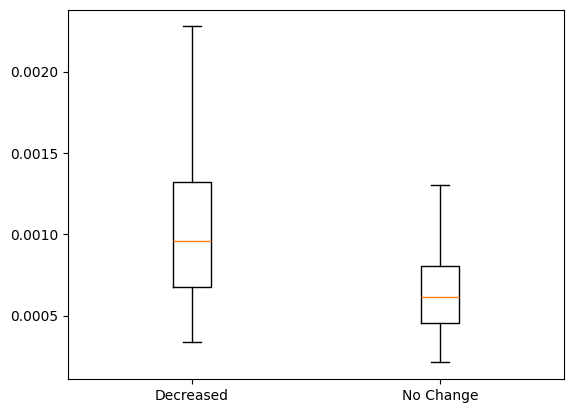

TtestResult(statistic=np.float64(0.9383171088579029), pvalue=np.float64(0.34819579674651324), df=np.float64(1982.0))

In [37]:
plt.boxplot([df_shift["decreased"], df_shift["nochange"]], labels = ["Decreased", "No Change"], showfliers=False)
plt.show()
scipy.stats.ttest_ind(df_shift["decreased"], df_shift["nochange"])

We can also observe larger embedding shift of EP300/CREBBP associated regulators on sensitive enhancers. 

In [38]:
# we select top 50 factors with the highest cosine similarity with EP300 
with h5py.File(os.path.join("tmp_starr","starr_emb.h5"), "r") as f:
    emb_all_wt = f["wt"][:,...].mean(axis = 0)
    ser_sim_with_ep300 = pd.DataFrame(data = cosine_similarity(emb_all_wt), columns= list_factors, index = list_factors)["ep300"]
ser_sim_with_ep300 = ser_sim_with_ep300.loc[~ser_sim_with_ep300.index.isin(["ep300","crebbp"])].sort_values(ascending = False).head(50)
ser_sim_with_ep300

med1       0.905289
brd4       0.890231
smarca4    0.885910
rxra       0.872736
tcf12      0.872508
myc        0.871053
foxm1      0.867882
nipbl      0.854444
rela       0.847948
nr3c1      0.847657
stat3      0.844953
t          0.843753
tcf7l2     0.842494
cdk9       0.829535
ets1       0.827677
runx1      0.826080
sox2       0.824894
stat1      0.824863
cdk8       0.824382
smarcc1    0.815441
sin3a      0.814455
junb       0.814285
tp53       0.814057
hdac2      0.813871
tead4      0.813280
sp1        0.808916
e2f1       0.807150
chd1       0.807117
bcl11a     0.804768
rbpj       0.804572
smad3      0.804470
tcf7l1     0.800667
gabpa      0.797082
tal1       0.794878
smad1      0.788872
erg        0.788513
jun        0.786361
taf1       0.785351
tp73       0.782868
e2f4       0.782279
zbtb17     0.777247
hdac1      0.777213
zeb1       0.776094
rnf2       0.775832
pou5f1     0.775517
lef1       0.775149
vdr        0.772557
kdm1a      0.771104
gata3      0.770577
hsf1       0.770509


/tmp/ipykernel_18221/844556973.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([v1, v2], labels = ["Related", "Others"], showfliers=False)


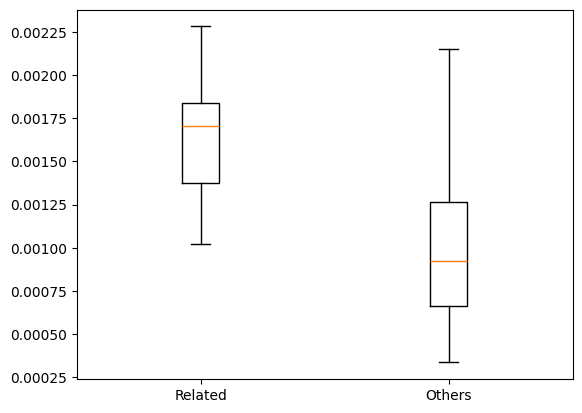

MannwhitneyuResult(statistic=np.float64(40344.0), pvalue=np.float64(1.793880419442975e-17))

In [43]:
v1 = df_shift.loc[ser_sim_with_ep300.index,"decreased"]
v2 = df_shift.loc[~df_shift.index.isin(ser_sim_with_ep300.index),"decreased"]
plt.boxplot([v1, v2], labels = ["Related", "Others"], showfliers=False)
plt.show()
scipy.stats.mannwhitneyu(v1, v2)

Furthermore, you will observe minimal embedding shift of BRD4, a well-known EP300/CREBBP associated regulator, on sensitive enhancers if fine-tuned well. The result can be validated by the STARR-seq data. See our manuscript for more details.   
The following images just present moderate results due to insufficient fine-tuning.   

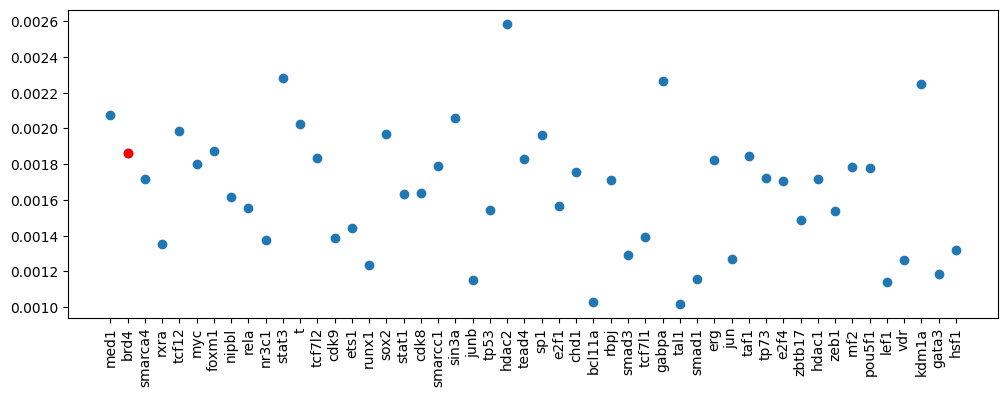

In [39]:

fig, ax = plt.subplots(1,1,figsize=(12,4))
ax.scatter(range(50),df_shift.loc[ser_sim_with_ep300.index,"decreased"])
ax.scatter(ser_sim_with_ep300.index.get_loc("brd4"),df_shift.loc["brd4","decreased"], color = "red")

ax.set_xticks(range(50))
ax.set_xticklabels(ser_sim_with_ep300.index, rotation = 90)
fig.show()
